# Ex 1

In [5]:
import random
import numpy as np
import statistics

class Network():
    def __init__(self):
        self.comb2bit = [ [-1,-1], [-1,1], [1,-1], [1,1] ]
        self.desiredOr = [-1, 1, 1, 1]
        self.w0 = 0
        self.w1 = 0
        self.w2 = 0
        self.alpha = 10e-4
        self.vw0 = 0
        self.vw1 = 0
        self.vw2 = 0
        
    def randweights(self):
        self.w0 = random.randint(1, 10)/10
        self.w1 = random.randint(1, 10)/10
        self.w2 = random.randint(1, 10)/10
        
    def output(self,combination):
        x = self.w0 + self.w1*combination[0] + self.w2*combination[1]
        o = 1 if x > 0 else -1
        return o

    def error(self,output):
        a = np.array(output)
        b = np.array(self.desiredOr)
        return np.sum(a != b)
    
    def vweights(self, combination, output, desired):
        self.vw0 += self.alpha*(desired-output)
        self.vw1 += self.alpha*combination[0]*(desired-output)
        self.vw2 += self.alpha*combination[1]*(desired-output)
    
    def updateweights(self):
        self.w0 += self.vw0
        self.w1 += self.vw1 
        self.w2 += self.vw2

In [4]:
random.seed(1)
epochs = []
x = 0
runs = 30
for x in range(runs):
    n = Network()
    epoch_num = 0
    n.randweights()
    while (True):
        epoch_num += 1
        outputs = []

        for c in n.comb2bit:
            outputs.append(n.output(c))
        #print('Outputs are', outputs)

        e = n.error(outputs)
        #print('Nº errors is:', e)

        if ( e == 0):
            break
        else:
            for count in range(4):
                n.vweights(n.comb2bit[count], outputs[count], n.desiredOr[count])
            n.updateweights()
            
    epochs.append(epoch_num)
print(epochs)
print('Average is:', statistics.mean(epochs))
print('Standard deviation is:',statistics.stdev(epochs))

    

[14, 7, 1, 9, 1, 7, 7, 11, 16, 9, 7, 1, 1, 2, 7, 13, 1, 1, 1, 1, 9, 1, 1, 7, 1, 1, 7, 9, 1, 7]
Average is: 5.366666666666666
Standard deviation is: 4.589969073093415


# Ex 2/3 Code

In [8]:
import math 
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import statistics
import timeit
import random

 

class Plants():
    
    def __init__(self):
        self.dataset = None
        self.training_set = None
        self.test_set = None
        self.test_class = None
        self.dev_class = None
        
    def loadfile(self, file):
        self.dataset = pd.read_csv(file, header=None, names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'])

    
    def splitdataset(self):
        #randomize the indices
        indexes = np.random.permutation(self.dataset.shape[0])
        
        # 70% of the dataset as a training set and 30% as test set
        div = int(0.70 * len(indexes))
        training_set_indexes, test_set_indexes = indexes[:div], indexes[div:]
        
        #split the dataset randomly
        self.training_set, self.test_set = self.dataset.loc[training_set_indexes,:], self.dataset.loc[test_set_indexes,:]
        self.dev_class, self.test_class  = list(self.training_set.iloc[:,-1]), list(self.test_set.iloc[:,-1])
    
    def euclidean_distance(self, row1, row2, data_len):
        dist = 0.0
        for i in range(data_len):
            dist += np.square(row1[i] - row2[i])
        return np.sqrt(dist)
    
    
    def knn(self, dataset, testInstance, k): 
        distances = {}
        length = testInstance.shape[1]
        for x in range(len(dataset)):
            d = self.euclidean_distance(testInstance, dataset.iloc[x], length)
            distances[x] = d[0]

        # Sort values based on distance
        sort_distances = sorted(distances.items(), key=operator.itemgetter(1))
        neighbors = []
        
        # Getting nearest k neighbors
        for x in range(k):
            neighbors.append(sort_distances[x][0])
            
        # Initializing counts for class
        counts = {"Iris-setosa" : 0, "Iris-versicolor" : 0, "Iris-virginica" : 0}
        
        # Getting the class with higher count
        for x in range(len(neighbors)):
            response = dataset.iloc[neighbors[x]][-1] 
            if response in counts:
                counts[response] += 1
            else:
                counts[response] = 1
                
        # Sorting in reverse to get the class with higher count
        sort_counts = sorted(counts.items(), key=operator.itemgetter(1), reverse = True)
        
        return(sort_counts[0][0])

    def splitfeature(self, feature):
        # Get average of the feature sepal length
        avg = self.dataset[feature].mean()
        
        # Split the dataset according to the average of the feature
        p1, p2 = self.dataset[self.dataset[feature] >= avg], self.dataset[self.dataset[feature] < avg]
        return p1, p2
    
    def entropy(self, data):
        count = (data['class'] == 'Iris-setosa').sum()
        p1  = count / len(data) 
        p2 = (len(data) - count) / len(data)
        if p1 or p2 != 1:
            e = -(p1 * math.log2(p1) + p2 * math.log2(p2))
        else:
            e = 0
        return e, count

# Ex 2

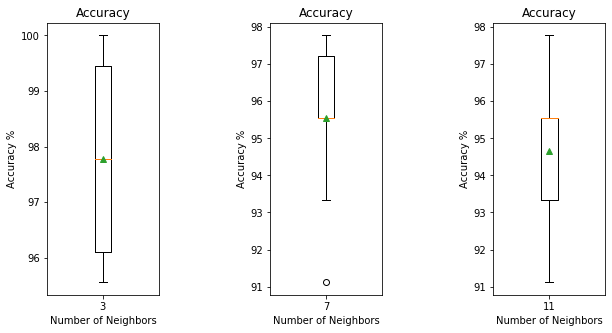

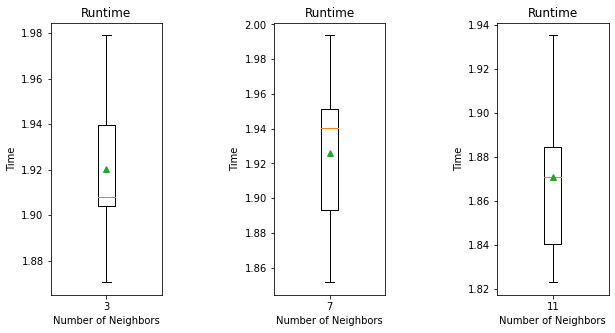

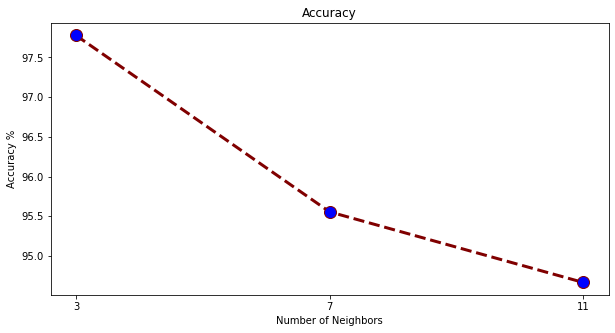

Average Accuracy k = 3: 97.77777777777777
Average Accuracy k = 7: 95.55555555555556
Average Accuracy k = 11: 94.66666666666667
As we increase the value of k the predictions become less accurate because of the majority average
k should always be odd to prevent ties.


In [34]:
random.seed(1)
p = Plants()
# iris.data file is in the same directory
p.loadfile("iris.data")

# k values for the number of neighbors that need to be considered
k_n = [3, 7, 11]
accuracies = []
runtimes = []
for k in k_n:
    x = 0
    accuracy = []
    runtime = []
    for x in range(10):
        start = timeit.default_timer()
        # Splits the dataset
        p.splitdataset()

        # Creating a list of list of all columns except 'class' by iterating through the test set
        row_list_test = []
        for index, rows in p.test_set.iterrows(): 
            my_list =[rows.sepal_length, rows.sepal_width, rows.petal_length, rows.petal_width]       
            row_list_test.append([my_list])
        
        # knn 
        test_set_obs = []
        for i in range(len(row_list_test)):
            test_set_obs.append(p.knn(p.test_set, pd.DataFrame(row_list_test[i]), k))

        # check accuracy
        count = 0
        for i,j in zip(p.test_class, test_set_obs):
            if i == j:
                count += 1
            else:
                pass
        accuracy_test = count/(len(p.test_class))
        accuracy.append(accuracy_test * 100)
        stop = timeit.default_timer()
        runtime.append(stop-start)
    runtimes.append(runtime)
    accuracies.append(accuracy)
    

    
fig,(ax,ax2,ax3) = plt.subplots(1,3,figsize =(10, 5))
ax.boxplot(accuracies[0], positions=[3],showmeans=True)
ax.set_title('Accuracy')
ax.set_xlabel('Number of Neighbors')
ax.set_ylabel('Accuracy %')
ax2.boxplot(accuracies[1],positions=[7],showmeans=True)
ax2.set_title('Accuracy')
ax2.set_xlabel('Number of Neighbors')
ax2.set_ylabel('Accuracy %')
ax3.boxplot(accuracies[2],positions=[11],showmeans=True)
ax3.set_title('Accuracy')
ax3.set_xlabel('Number of Neighbors')
ax3.set_ylabel('Accuracy %')
fig.subplots_adjust(wspace=1)





fig2,(ax4,ax5,ax6) = plt.subplots(1,3,figsize =(10, 5))
ax4.boxplot(runtimes[0], positions=[3],showmeans=True)
ax4.set_title('Runtime')
ax4.set_xlabel('Number of Neighbors')
ax4.set_ylabel('Time')
ax5.boxplot(runtimes[1],positions=[7],showmeans=True)
ax5.set_title('Runtime')
ax5.set_xlabel('Number of Neighbors')
ax5.set_ylabel('Time')
ax6.boxplot(runtimes[2],positions=[11],showmeans=True)
ax6.set_title('Runtime')
ax6.set_xlabel('Number of Neighbors')
ax6.set_ylabel('Time')
fig2.subplots_adjust(wspace=1)

# Plotting a graph for accuracy
data = {'3':statistics.mean(accuracies[0]), '7':statistics.mean(accuracies[1]), '11':statistics.mean(accuracies[2])}
ks = list(data.keys())
accuracies_vals = list(data.values())
  
# Creating the graph
fig3, ax7 = plt.subplots(1,1,figsize =(10, 5))
ax7.plot(ks, accuracies_vals, color='maroon', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='blue', markersize=12)
ax7.set_xlabel('Number of Neighbors')
ax7.set_ylabel('Accuracy %')
ax7.set_title('Accuracy')
plt.show()


print('Average Accuracy k = 3:', statistics.mean(accuracies[0]))
print('Average Accuracy k = 7:', statistics.mean(accuracies[1]))
print('Average Accuracy k = 11:', statistics.mean(accuracies[2]))


print('As we increase the value of k the predictions become less accurate because of the majority average')
print('k should always be odd to prevent ties.')

# Ex 3

In [48]:
p = Plants()
# iris.data file is in the same directory
p.loadfile("iris.data")

feature  = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
gains = []

initial_entropy, total = p.entropy(p.dataset)
print('Entropy of the complete dataset is: ', initial_entropy)
print('Nº Setosa of the complete dataset is: ', total)

for alpha in feature:
    print ('-------------------------------FEATURE------------------------------------------------- ', alpha)
    big, small = p.splitfeature(alpha)
    
    print('Total iris Big: ',len(big))
    ent1, count1 = p.entropy(big)
    print('Entropy of the big dataset is: ', ent1)
    print('Nº Setosa of the big dataset is: ', count1)

    print('Total iris Small: ',len(small))
    ent2, count2 = p.entropy(small)
    print('Entropy of the small dataset is: ', ent2)
    print('Nº Setosa of the small dataset is: ', count2)

    gain = initial_entropy - ((ent1*len(big)) + (ent2*len(small)))/len(p.dataset)
    print ('Information gain is:',gain)
    gains.append(gain)

print('The variable that has the largest information gain is selected to split the dataset. Generally, a larger gain indicates a smaller entropy.')
print('The feature that has the largest information gain is petal_length ')
print('The process is then repeated on each feature, excluding the one that was previously chosen. The process stops when no more splits are possible or when we reach the tree depth that we want')

Entropy of the complete dataset is:  0.9182958340544896
Nº Setosa of the complete dataset is:  50
-------------------------------FEATURE-------------------------------------------------  sepal_length
Total iris Big:  70
Entropy of the big dataset is:  0
Nº Setosa of the big dataset is:  0
Total iris Small:  80
Entropy of the small dataset is:  0.954434002924965
Nº Setosa of the small dataset is:  50
Information gain is: 0.40926436582784154
-------------------------------FEATURE-------------------------------------------------  sepal_width
Total iris Big:  67
Entropy of the big dataset is:  0.9530483471581299
Nº Setosa of the big dataset is:  42
Total iris Small:  83
Entropy of the small dataset is:  0.4574321808988396
Nº Setosa of the small dataset is:  8
Information gain is: 0.2394884322265003
-------------------------------FEATURE-------------------------------------------------  petal_length
Total iris Big:  93
Entropy of the big dataset is:  0
Nº Setosa of the big dataset is:  0
To